## Orel Ben Zaken ID: 315628313.
## Omer Luxebmourg ID: 205500390.

# Assignment 3: Image Classification

**Deadline**: Sunday, May 2nd, by 9pm.

**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

## Question 1. Data (20%)

Download the data from the course website. 

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set the random seed manually for reproducibility.
np.random.seed(1111)
torch.manual_seed(1111)

After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.


### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [ ]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files
# this code is to overcome slow extracting in colab:

zip_path = '/content/gdrive/My\ Drive/Colab\ Notebooks/Assignment3/data.zip'
!cp {zip_path} .
!mkdir ./assignment3_data
!unzip -q data.zip -d ./assignment3_data
!rm data.zip

import glob
path = "/content/assignment3_data/data/train/*.jpg" # TODO - UPDATE ME!
images = {}
person=set()
for file in glob.glob(path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)   # read the image as a numpy array
    images[filename] = img[:, :, :3]/255 -0.5# remove the alpha channel
    person.add(filename[:4])

person=list(person)
#Create the numpy arrays train_data
shoes_np=np.empty((len(person),3, 2, 224, 224, 3))
keys_im=images.keys()

for i in range(len(person)):   #person i.
    for j in range(3):# pair of shoes.
        for k,side in enumerate(["left","right"]): # left or right.
            name=person[i]+"_"+str(j+1)+"_"+side+"_w.jpg"
            if name not in keys_im:
                name= person[i]+"_"+str(j+1)+"_"+side+"_m.jpg"
            shoes_np[i,j,k]=images[name]

#Train and Validation partition.
reindex = np.random.permutation(len(shoes_np)) #shuffle
shoes_np = shoes_np[reindex]
train_data = shoes_np[:9*len(shoes_np)//10]
valid_data= shoes_np[9*len(shoes_np)//10:]


#test_m
path = "/content/assignment3_data/data/test_m/*.jpg" # TODO - UPDATE ME!
images = {}
person=set()
for file in glob.glob(path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)   # read the image as a numpy array
    images[filename] = img[:, :, :3]/255 -0.5# remove the alpha channel
    person.add(filename[:4])

person=list(person)
#Create the numpy arrays train_data
test_m=np.empty((len(person),3, 2, 224, 224, 3))
keys_im=images.keys()

for i in range(len(person)):   #person i.
    for j in range(3):# pair of shoes.
        for k,side in enumerate(["left","right"]): # left or right.
            name=person[i]+"_"+str(j+1)+"_"+side+"_w.jpg"
            if name not in keys_im:
                name= person[i]+"_"+str(j+1)+"_"+side+"_m.jpg"
            test_m[i,j,k]=images[name]


#test_w
path = "/content/assignment3_data/data/test_w/*.jpg" # TODO - UPDATE ME!
images = {}
person=set()
for file in glob.glob(path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)   # read the image as a numpy array
    images[filename] = img[:, :, :3]/255 -0.5# remove the alpha channel
    person.add(filename[:4])

person=list(person)
#Create the numpy arrays train_data
test_w=np.empty((len(person),3, 2, 224, 224, 3))
keys_im=images.keys()

for i in range(len(person)):   #person i.
    for j in range(3):# pair of shoes.
        for k,side in enumerate(["left","right"]): # left or right.
            name=person[i]+"_"+str(j+1)+"_"+side+"_w.jpg"
            if name not in keys_im:
                name= person[i]+"_"+str(j+1)+"_"+side+"_m.jpg"
            test_w[i,j,k]=images[name]


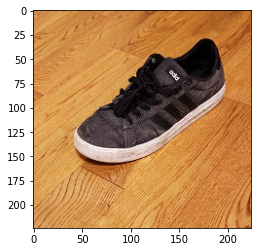

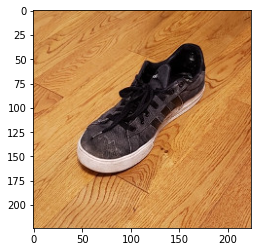

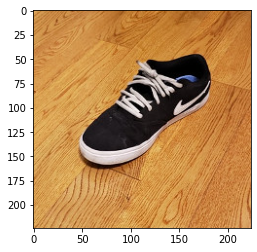

In [ ]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(100, 3, 2, 224, 224, 3)
(300, 448, 224, 3)


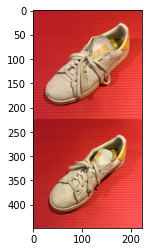

In [ ]:
# Your code goes here
def generate_same_pair(data):
    same_pair=np.empty((3*len(data),448, 224, 3))
    for i in range(len(data)): # i-person.
        for j in range(3): # j-pair.
            same_pair[j+3*i]=np.concatenate((data[i,j,0],data[i,j,1]),axis=0)

    return same_pair
# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(100, 3, 2, 224, 224, 3)
(300, 448, 224, 3)


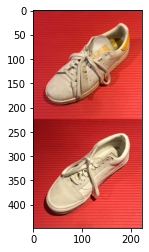

In [ ]:
# Your code goes here
def generate_different_pair(data):
    different_pair=np.empty((3*len(data),448, 224, 3))
    for i in range(len(data)): # i-person.
        different_pair[3*i]=np.concatenate((data[i,0,0],data[i,1,1]),axis=0)
        different_pair[1+3*i]=np.concatenate((data[i,1,0],data[i,2,1]),axis=0)
        different_pair[2+3*i]=np.concatenate((data[i,2,0],data[i,0,1]),axis=0)

    return different_pair

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]+0.5) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Write your explanation here:**

There are two main reasons:
1. Because each person has the same size of a shoe, which won't be different when we insert different pairs to the model.
2. The background and the angle of the picture is probably the same for every shoe from the same person. If we give the model 2 shoes from different persons, the model can learn to identify the background, instead of the shoe itself.


### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**

Giving unbalanced data to the model to train on, the model will learn the distribution of the data, thus it will 'prefer' as binary classifier to classify every example as the majority class (prefer == minimal loss for the CE loss function).

When using unbalanced data, accuracy of correctnce is a wrong metric to see if the model generalize the problem. A good method is to take the confusion matrix.

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [ ]:
# def weight_init(m, mean=0, std=1):
#     if isinstance(m, (nn.Linear, nn.Conv2d)):
#         m.weight.data.normal_(mean, std)
#         if m.bias.data is not None:
#             m.bias.data.zero_()
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        torch.nn.init.kaiming_normal_(m.weight.data)
    elif classname.find("Conv2d") != -1:
        torch.nn.init.kaiming_normal_(m.weight.data)

In [ ]:
class CNN(nn.Module):
    def __init__(self, n=4, k_size=3):
        super(CNN, self).__init__()
        
        H0=448
        W0=224
        pad=int((k_size-1)/2)
        pool=2


        self.conv1 = nn.Conv2d(in_channels=3,
                         out_channels=n,
                         kernel_size=k_size,
                         stride=1,
                         padding=pad)
        self.pool = nn.MaxPool2d(pool, pool)
        #calculate the output size
        H1=int(np.floor((H0+2*pad-k_size+2)/pool))
        W1=int(np.floor((W0+2*pad-k_size+2)/pool))

        self.conv2 = nn.Conv2d(in_channels=n,
                         out_channels=2*n,
                         kernel_size=k_size,
                         stride=1,
                         padding=pad)
        
        #calculate the output size
        H2=int(np.floor((H1+2*pad-k_size+2)/pool))
        W2=int(np.floor((W1+2*pad-k_size+2)/pool))

        self.conv3 = nn.Conv2d(in_channels=2*n,
                         out_channels=4*n,
                         kernel_size=k_size,
                         stride=1,
                         padding=pad)
       
        #calculate the output size
        H3=int(np.floor((H2+2*pad-k_size+2)/pool))
        W3=int(np.floor((W2+2*pad-k_size+2)/pool))

        self.conv4 = nn.Conv2d(in_channels=4*n,
                         out_channels=8*n,
                         kernel_size=k_size,
                         stride=1,
                         padding=pad)
        
        #calculate the output size
        H4=int(np.floor((H3+2*pad-k_size+2)/pool))
        W4=int(np.floor((W3+2*pad-k_size+2)/pool))
        
        self.fc1=nn.Linear(in_features=H4*W4*8*n, out_features=100)
         
        self.fc2=nn.Linear(in_features=100, out_features=2)

    
    def forward(self, x):
        x=x.float()
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.pool(F.leaky_relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [ ]:
class CNNChannel(nn.Module):
    def __init__(self, n=4, k_size=3):
        super(CNNChannel, self).__init__()
        
        H0=224
        W0=224
        pad=int((k_size-1)/2)
        pool=2


        self.conv1 = nn.Conv2d(in_channels=6,
                         out_channels=n,
                         kernel_size=k_size,
                         stride=1,
                         padding=pad)
        self.pool = nn.MaxPool2d(pool, pool)
        #calculate the output size
        H1=int(np.floor((H0+2*pad-k_size+2)/pool))
        W1=int(np.floor((W0+2*pad-k_size+2)/pool))

        self.conv2 = nn.Conv2d(in_channels=n,
                         out_channels=2*n,
                         kernel_size=k_size,
                         stride=1,
                         padding=pad)
        
        #calculate the output size
        H2=int(np.floor((H1+2*pad-k_size+2)/pool))
        W2=int(np.floor((W1+2*pad-k_size+2)/pool))

        self.conv3 = nn.Conv2d(in_channels=2*n,
                         out_channels=4*n,
                         kernel_size=k_size,
                         stride=1,
                         padding=pad)
       
        #calculate the output size
        H3=int(np.floor((H2+2*pad-k_size+2)/pool))
        W3=int(np.floor((W2+2*pad-k_size+2)/pool))

        self.conv4 = nn.Conv2d(in_channels=4*n,
                         out_channels=8*n,
                         kernel_size=k_size,
                         stride=1,
                         padding=pad)
        
        #calculate the output size
        H4=int(np.floor((H3+2*pad-k_size+2)/pool))
        W4=int(np.floor((W3+2*pad-k_size+2)/pool))
        
        self.fc1=nn.Linear(in_features=H4*W4*8*n, out_features=100)
         
        self.fc2=nn.Linear(in_features=100, out_features=2)

    
    def forward(self, x):
        
        x_new=torch.cat((x[:,:,:224],x[:,:,224:]),dim=1).float()
        x = self.pool(F.relu(self.conv1(x_new)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**

In the concatenated picture (CNN model) the filters of the convolutional layer will learn each shoe seperatly. For the 6 channel model (CNNChannel), the filters will learn the conenctions between each pair shoes (between all the 6 channels), because the filters are learning the spacial connection between the pixels in size of the kernel including pixels from different channels.

## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**

Accuracy is a metric to check the error of the model.
We want to know if the model error is caused by specific class, which accuracy won't tell us about. For example 50% accuracy might be 50% accuracy for each class, but also 100% accuracy for specific class and 0% for the other - the model has a constant decision!

Hence, we wish to track the false positives and false negatives separately (to see if the model decision isn't prone to specific class).

In [ ]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).permute(0,3,1,2)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).permute(0,3,1,2)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [ ]:
# Shuffeling the data according to random permutation
def shuffle_data(x, y_label):
    reindex = np.random.permutation(len(x))
    return x[reindex], y_label[reindex]

In [ ]:
def train_model(model, num_epochs=5, train_data=train_data, batch_size=50, learning_rate=1e-3, weight_decay=1e-5):
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    iters_train = 0
    max_valid_acc=0
    epoch_max_valid_acc=0

    criterion = nn.CrossEntropyLoss() #choice of loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) #choice of optimizer

    #obtaining the positive and negative samples
    train_x_pos = torch.tensor(generate_same_pair(train_data)).permute(0,3,1,2)
    train_y_pos = torch.ones(len(train_x_pos))
    train_x_neg = torch.tensor(generate_different_pair(train_data)).permute(0,3,1,2)
    train_y_neg = torch.zeros(len(train_x_pos))

    valid_x_pos = torch.tensor(generate_same_pair(valid_data)).permute(0,3,1,2)
    valid_x_neg = torch.tensor(generate_different_pair(valid_data)).permute(0,3,1,2)
    valid_x = torch.cat((valid_x_pos,valid_x_neg),dim=0)
    valid_y_label = torch.cat((torch.ones(len(valid_x_pos)),torch.zeros(len(valid_x_neg))),dim=0)
    

    for epoch in range(num_epochs):        
        tr_x_pos, tr_y_pos = shuffle_data(train_x_pos, train_y_pos)   # shuffle the data before train pos
        tr_x_neg, tr_y_neg = shuffle_data(train_x_neg, train_y_neg)   # shuffle the data before train neg

        epoch_loss = []
        epoch_acc = []
        for i in range(0, len(tr_x_pos), batch_size//2):              # iterate over each minibatch

            # since len(train_x) does not divide batch_size evenly, we will skip over
            # the "last" minibatch
            if len(tr_x_pos[i:(i + batch_size//2)]) != batch_size//2:
                continue
            
            # minibatch that we are working with:
            x = torch.cat((tr_x_pos[i:(i + batch_size//2)],tr_x_neg[i:(i + batch_size//2)]),dim=0)
            y_label = torch.cat((train_y_pos[i:(i + batch_size//2)],train_y_neg[i:(i + batch_size//2)]),dim=0)

            optimizer.zero_grad()
            model_out = model(x)
            loss = criterion(model_out, y_label.long())

            iters_train += 1
            epoch_loss.append(loss)                                                         # train loss append
    
           # train accuracy append
            loss.backward()
            optimizer.step()

        # validation check:
        with torch.no_grad():
            model_out = model(valid_x)
        valid_losses.append(criterion(model_out, valid_y_label.long()))

        valid_accuracies.append(get_accuracy(model,valid_data, batch_size))

        train_losses.extend(epoch_loss)

        train_accuracies.append(get_accuracy(model,train_data, batch_size))

        epoch_loss = torch.FloatTensor(epoch_loss)

        total_acc_train=(train_accuracies[-1][0]+train_accuracies[-1][1])/2
                
        total_acc_valid=(valid_accuracies[-1][0]+valid_accuracies[-1][1])/2
        if total_acc_valid >= max_valid_acc:
            path='/content/gdrive/My Drive/Colab Notebooks/Assignment3/models/model_max_valid.pt'
            epoch_max_valid_acc=epoch+1
            max_valid_acc=total_acc_valid

            #save model

            torch.save(model, path.format(epoch))


        
        print('Lr:{} Epoch:{}, Mean Train Loss: {:.4f}, Train Accuracy: total-{:.4f} pos-{:.4f} neg-{:.4f} ,\n\t '\
              'Valid Loss: {:.4f}, Valid Accuracy: total-{:.4f} pos-{:.4f} neg-{:.4f}'  
              .format(learning_rate, epoch+1, torch.mean(epoch_loss), total_acc_train, *(train_accuracies[-1]), valid_losses[-1], total_acc_valid, *(valid_accuracies[-1])))
    
    print('epoch max valid acc = {}'.format(epoch_max_valid_acc))
    return iters_train, train_losses, train_accuracies, valid_losses, valid_accuracies


In [ ]:
def plot_learning_curve(iters_train, train_losses, train_accs, iters_valid, valid_losses, valid_accs):
    """
    Plot the learning curve.
    """
    d = iters_train // iters_valid
    tmp_list=list(zip(*train_accs))
    train_acc_pos=tmp_list[0]
    train_acc_neg=tmp_list[1]

    tmp_list=list(zip(*valid_accs))
    valid_acc_pos=tmp_list[0]
    valid_acc_neg=tmp_list[1]

    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(range(iters_train), train_losses, label="Train")
    plt.plot(range(d, iters_train+1, d), valid_losses, label="Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    
    plt.title("Learning Curve: Accuracy per Iteration")
    train_acc_total=(np.array(train_acc_pos)+np.array(train_acc_neg))/2
    valid_acc_total=(np.array(valid_acc_pos)+np.array(valid_acc_neg))/2
    plt.plot(range(d, iters_train+1, d), train_acc_total, label="Train")
    plt.plot(range(d, iters_train+1, d), valid_acc_total, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend(loc='best')
    plt.show()


    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(range(d, iters_train+1, d), train_acc_pos, label="Train pos")
    plt.plot(range(d, iters_train+1, d), valid_acc_pos, label="Validation pos")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend(loc='best')
    plt.show()


    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(range(d, iters_train+1, d), train_acc_neg, label="Train neg")
    plt.plot(range(d, iters_train+1, d), valid_acc_neg, label="Validation neg")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend(loc='best')
    plt.show()

### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

n= 4
Lr:0.0005 Epoch:1, Mean Train Loss: 0.6940, Train Accuracy: total-0.6667 pos-1.0000 neg-0.3333 ,
	 Valid Loss: 0.6931, Valid Accuracy: total-0.5278 pos-0.6111 neg-0.4444
Lr:0.0005 Epoch:2, Mean Train Loss: 0.6929, Train Accuracy: total-0.5000 pos-1.0000 neg-0.0000 ,
	 Valid Loss: 0.6929, Valid Accuracy: total-0.5000 pos-0.7500 neg-0.2500
Lr:0.0005 Epoch:3, Mean Train Loss: 0.6925, Train Accuracy: total-0.5000 pos-0.0000 neg-1.0000 ,
	 Valid Loss: 0.6928, Valid Accuracy: total-0.5000 pos-0.0000 neg-1.0000
Lr:0.0005 Epoch:4, Mean Train Loss: 0.6919, Train Accuracy: total-0.5000 pos-1.0000 neg-0.0000 ,
	 Valid Loss: 0.6925, Valid Accuracy: total-0.5139 pos-0.8056 neg-0.2222
Lr:0.0005 Epoch:5, Mean Train Loss: 0.6910, Train Accuracy: total-0.5333 pos-0.0667 neg-1.0000 ,
	 Valid Loss: 0.6918, Valid Accuracy: total-0.5139 pos-0.0278 neg-1.0000
Lr:0.0005 Epoch:6, Mean Train Loss: 0.6891, Train Accuracy: total-0.7333 pos-0.8000 neg-0.6667 ,
	 Valid Loss: 0.6904, Valid Accuracy: total-0.61

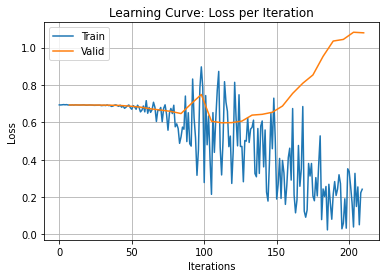

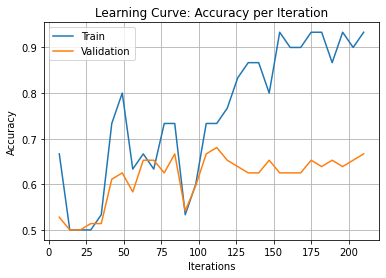

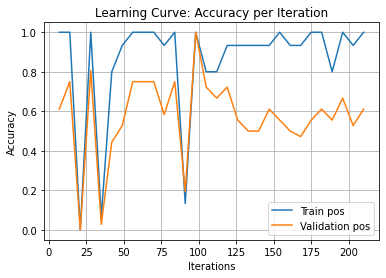

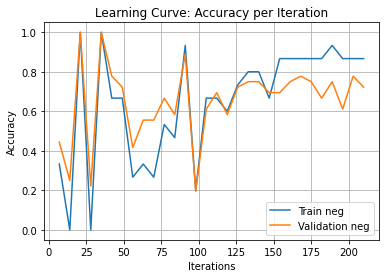

In [ ]:
# Write your code here. Remember to include your results so that we can
# see that your model attains a high training accuracy.

##CNNChannel##

small_subset=train_data[:5]
n=4
num_epochs=30
lr=0.0005
print("n=",n)
model_CNNChannel=CNNChannel(n=n)
iters_train, train_losses, train_accuracies, valid_losses, valid_accuracies =train_model(model_CNNChannel, num_epochs=num_epochs,
                                                                                         train_data=small_subset, 
                                                                                         batch_size=5, 
                                                                                         learning_rate=lr, weight_decay=0)

plot_learning_curve(iters_train, train_losses, train_accuracies, num_epochs, valid_losses, valid_accuracies)


In [ ]:
#save or load the CNNChannel model  
path='/content/gdrive/My Drive/Colab Notebooks/Assignment3/models/CNNChannel_Q3b.pt'

#save model

# torch.save(model_CNNChannel, path) 

#load model
model = torch.load(path)


#testing the model performence

model.eval()
small_subset=train_data[:5]
pos, neg = get_accuracy(model,small_subset, 5)
print(pos,neg)

model_CNNChannel=model

1.0 0.8666666666666667


n= 4
Lr:0.000254 Epoch:1, Mean Train Loss: 0.6944, Train Accuracy: total-0.5000 pos-1.0000 neg-0.0000 ,
	 Valid Loss: 0.6932, Valid Accuracy: total-0.5000 pos-1.0000 neg-0.0000
Lr:0.000254 Epoch:2, Mean Train Loss: 0.6934, Train Accuracy: total-0.5000 pos-0.4000 neg-0.6000 ,
	 Valid Loss: 0.6931, Valid Accuracy: total-0.5000 pos-0.0000 neg-1.0000
Lr:0.000254 Epoch:3, Mean Train Loss: 0.6934, Train Accuracy: total-0.5000 pos-0.0000 neg-1.0000 ,
	 Valid Loss: 0.6932, Valid Accuracy: total-0.5000 pos-0.0000 neg-1.0000
Lr:0.000254 Epoch:4, Mean Train Loss: 0.6933, Train Accuracy: total-0.5000 pos-1.0000 neg-0.0000 ,
	 Valid Loss: 0.6932, Valid Accuracy: total-0.5000 pos-1.0000 neg-0.0000
Lr:0.000254 Epoch:5, Mean Train Loss: 0.6935, Train Accuracy: total-0.5000 pos-0.0000 neg-1.0000 ,
	 Valid Loss: 0.6932, Valid Accuracy: total-0.5000 pos-0.0000 neg-1.0000
Lr:0.000254 Epoch:6, Mean Train Loss: 0.6932, Train Accuracy: total-0.4667 pos-0.0000 neg-0.9333 ,
	 Valid Loss: 0.6931, Valid Accuracy

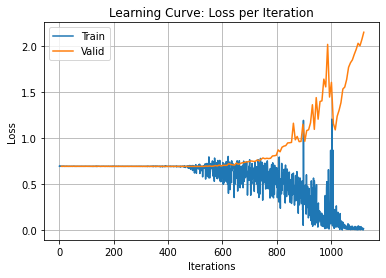

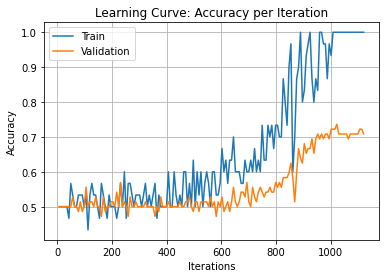

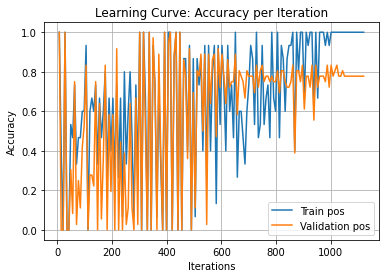

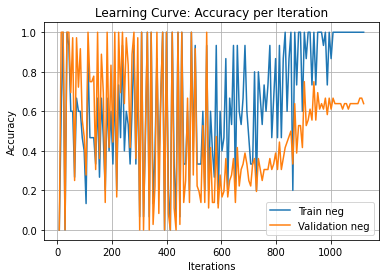

In [ ]:
##CNN Model##

small_subset=train_data[:5]
n=4
num_epochs=160
lr_list=[2.54e-4]
for lr in lr_list:
    print("n=",n)
    model_CNN=CNN(n=n)
    iters_train, train_losses, train_accuracies, valid_losses, valid_accuracies =train_model(model_CNN, num_epochs=num_epochs,
                                                                                         train_data=small_subset, 
                                                                                         batch_size=5, 
                                                                                         learning_rate=lr, weight_decay=0)

plot_learning_curve(iters_train, train_losses, train_accuracies, num_epochs, valid_losses, valid_accuracies)

In [ ]:
#save or load the CNN model  
path='/content/gdrive/My Drive/Colab Notebooks/Assignment3/models/CNN_Q3b.pt'

#save model

# torch.save(model_CNN, path) 

#load model
model = torch.load(path)


#testing the model performence

model.eval()
small_subset=train_data[:5]
pos, neg = get_accuracy(model,small_subset, 5)
print(pos,neg)

model_CNN=model

1.0 1.0


### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**

In the previous section we found the appropriate hyperparameters for the case of a small portion of the data and it gives us a tuning to the area where the hyperparameters corresponding to all the data, are located.

**CNNChannel Model:** In this section we used the same learning rate, kernel size and n (as in the previous section) when we take bacth size of 100 so that we get the same number of iterations in each epoch (3 iterations) as in the previous section.

We get in epoch 29 the max valid accurecy:

    Train accurecy = 91.33% and Valid accurecy = 84.72%  

**CNN Model:** In this section we used the same learning rate (as in the previous section) when we take bacth size of 100 so that we get the same number of iterations in each epoch (3 iterations) as in the previous section.
kernel size = 7 and n = 5.

We get in epoch 84 the max valid accurecy:

*for more epochs we have reached train accurecy > 90% but smaller valid accurecy.

    Train accurecy = 85.83% and Valid accurecy = 65.28%  




In [ ]:
# Include the training curves for the two models.

##CNNChannel##

n=4
num_epochs=60
lr_list=[5e-4]
for lr in lr_list:
    print("n=",n)
    model_CNNChannel=CNNChannel(n=n)
    iters_train_CNNChannel, train_losses_CNNChannel, train_accuracies_CNNChannel, valid_losses_CNNChannel, valid_accuracies_CNNChannel =train_model(model_CNNChannel, 
                                                                                                                                                    num_epochs=num_epochs,
                                                                                                                                                    train_data=train_data, 
                                                                                                                                                    batch_size=100, 
                                                                                                                                                    learning_rate=lr, weight_decay=0)

path='/content/gdrive/My Drive/Colab Notebooks/Assignment3/models/CNNChannel_curve.p'
CNNChannel_curve=(iters_train_CNNChannel, train_losses_CNNChannel, train_accuracies_CNNChannel, valid_losses_CNNChannel, valid_accuracies_CNNChannel)
pickle.dump( CNNChannel_curve, open( path, "wb" ) )


n= 4
Lr:0.0005 Epoch:1, Mean Train Loss: 0.6931, Train Accuracy: total-0.5000 pos-0.0000 neg-1.0000 ,
	 Valid Loss: 0.6923, Valid Accuracy: total-0.5000 pos-0.0000 neg-1.0000
Lr:0.0005 Epoch:2, Mean Train Loss: 0.6911, Train Accuracy: total-0.5833 pos-0.5900 neg-0.5767 ,
	 Valid Loss: 0.6882, Valid Accuracy: total-0.6111 pos-0.6667 neg-0.5556
Lr:0.0005 Epoch:3, Mean Train Loss: 0.6856, Train Accuracy: total-0.6133 pos-0.7200 neg-0.5067 ,
	 Valid Loss: 0.6783, Valid Accuracy: total-0.6389 pos-0.8333 neg-0.4444
Lr:0.0005 Epoch:4, Mean Train Loss: 0.6760, Train Accuracy: total-0.6267 pos-0.8667 neg-0.3867 ,
	 Valid Loss: 0.6636, Valid Accuracy: total-0.6806 pos-0.9444 neg-0.4167
Lr:0.0005 Epoch:5, Mean Train Loss: 0.6608, Train Accuracy: total-0.6183 pos-0.6333 neg-0.6033 ,
	 Valid Loss: 0.6378, Valid Accuracy: total-0.6667 pos-0.6944 neg-0.6389
Lr:0.0005 Epoch:6, Mean Train Loss: 0.6375, Train Accuracy: total-0.6633 pos-0.7900 neg-0.5367 ,
	 Valid Loss: 0.6053, Valid Accuracy: total-0.70

In [ ]:
#save or load the CNNChannel model 

# #load the best model (max valid accurecy)
# path='/content/gdrive/My Drive/Colab Notebooks/Assignment3/models/model_max_valid.pt'
# model = torch.load(path)

path='/content/gdrive/My Drive/Colab Notebooks/Assignment3/models/CNNChannel_Q3c.pt'

# #save model

# torch.save(model, path) 

#load model
model = torch.load(path)


#testing the model performence

model.eval()
small_subset=train_data
pos, neg = get_accuracy(model,small_subset, 100)
print(pos,neg)

model_CNNChannel=model

0.9333333333333333 0.8933333333333333


In [ ]:
##CNN Model##

n=5
num_epochs=140
lr_list=[2.55e-4]
for lr in lr_list:
    print("n=",n)
    model_CNN=CNN(n=n, k_size=7)
    iters_train_CNN, train_losses_CNN, train_accuracies_CNN, valid_losses_CNN, valid_accuracies_CNN =train_model(model_CNN, 
                                                                                                                 num_epochs=num_epochs,
                                                                                                                 train_data=train_data, 
                                                                                                                 batch_size=100, 
                                                                                                                 learning_rate=lr, weight_decay=0)

path='/content/gdrive/My Drive/Colab Notebooks/Assignment3/models/CNN_curve.p'    
CNN_curve=(iters_train_CNN, train_losses_CNN, train_accuracies_CNN, valid_losses_CNN, valid_accuracies_CNN)
pickle.dump( CNN_curve, open( path, "wb" ) )

n= 5
Lr:0.000255 Epoch:1, Mean Train Loss: 0.6935, Train Accuracy: total-0.4933 pos-0.0567 neg-0.9300 ,
	 Valid Loss: 0.6931, Valid Accuracy: total-0.5000 pos-0.1111 neg-0.8889
Lr:0.000255 Epoch:2, Mean Train Loss: 0.6932, Train Accuracy: total-0.5000 pos-0.0000 neg-1.0000 ,
	 Valid Loss: 0.6932, Valid Accuracy: total-0.5000 pos-0.0000 neg-1.0000
Lr:0.000255 Epoch:3, Mean Train Loss: 0.6932, Train Accuracy: total-0.5083 pos-0.4033 neg-0.6133 ,
	 Valid Loss: 0.6931, Valid Accuracy: total-0.5000 pos-0.4167 neg-0.5833
Lr:0.000255 Epoch:4, Mean Train Loss: 0.6932, Train Accuracy: total-0.5183 pos-0.8233 neg-0.2133 ,
	 Valid Loss: 0.6931, Valid Accuracy: total-0.5278 pos-0.9444 neg-0.1111
Lr:0.000255 Epoch:5, Mean Train Loss: 0.6931, Train Accuracy: total-0.5000 pos-0.0033 neg-0.9967 ,
	 Valid Loss: 0.6931, Valid Accuracy: total-0.5000 pos-0.0000 neg-1.0000
Lr:0.000255 Epoch:6, Mean Train Loss: 0.6931, Train Accuracy: total-0.5167 pos-0.8967 neg-0.1367 ,
	 Valid Loss: 0.6931, Valid Accuracy

In [ ]:
#save or load the CNN model 

# #load the best model (max valid accurecy)
# path='/content/gdrive/My Drive/Colab Notebooks/Assignment3/models/model_max_valid.pt'
# model = torch.load(path)

path='/content/gdrive/My Drive/Colab Notebooks/Assignment3/models/CNN_Q3c.pt'

# #save model

# torch.save(model, path) 

#load model
model = torch.load(path)


#testing the model performence

model.eval()
small_subset=train_data
pos, neg = get_accuracy(model,small_subset, 100)
print(pos,neg)

model_CNN=model

0.7666666666666667 0.95


### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.


##############################################
######CNNChannel Model - training curves######
##############################################



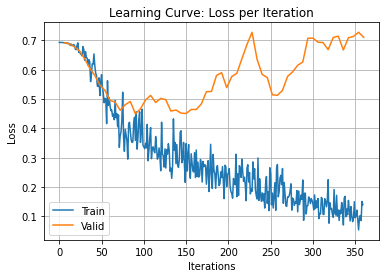

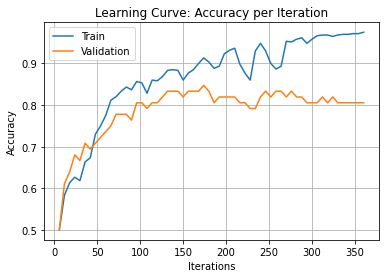

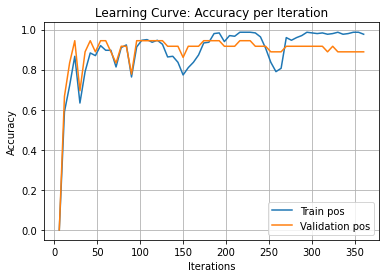

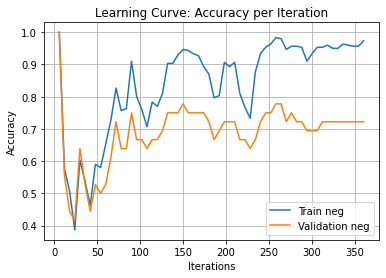


#######################################
######CNN Model - training curves######
#######################################



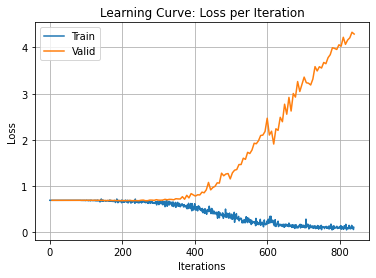

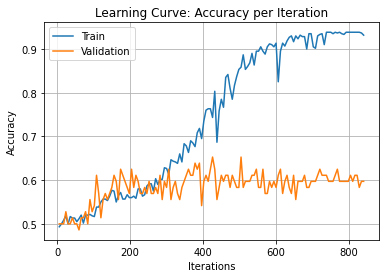

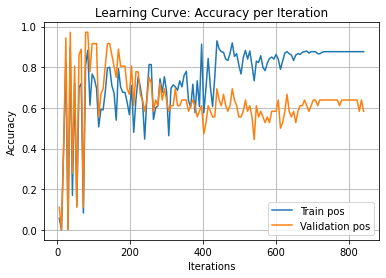

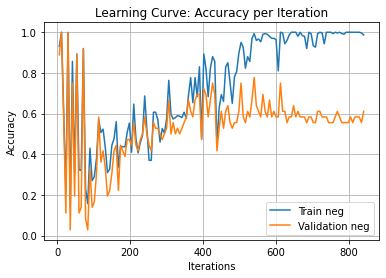

In [ ]:
# Include the training curves for the two models.

##CNNChannel##
num_epochs=60
path='/content/gdrive/My Drive/Colab Notebooks/Assignment3/models/CNNChannel_curve.p'    
CNNChannel_curve = pickle.load( open( path, "rb" ) )
iters_train_CNNChannel, train_losses_CNNChannel, train_accuracies_CNNChannel, valid_losses_CNNChannel, valid_accuracies_CNNChannel = CNNChannel_curve

print('\n##############################################')
print('######CNNChannel Model - training curves######')
print('##############################################\n')

plot_learning_curve(iters_train_CNNChannel, train_losses_CNNChannel,
                    train_accuracies_CNNChannel, num_epochs, valid_losses_CNNChannel, valid_accuracies_CNNChannel)

##CNN##
num_epochs=140
path='/content/gdrive/My Drive/Colab Notebooks/Assignment3/models/CNN_curve.p'    
CNN_curve = pickle.load( open( path, "rb" ) )
iters_train_CNN, train_losses_CNN, train_accuracies_CNN, valid_losses_CNN, valid_accuracies_CNN = CNN_curve

print('\n#######################################')
print('######CNN Model - training curves######')
print('#######################################\n')

plot_learning_curve(iters_train_CNN, train_losses_CNN,
                    train_accuracies_CNN, num_epochs, valid_losses_CNN, valid_accuracies_CNN)

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
# Write your code here. Make sure to include the test accuracy in your report
path='/content/gdrive/My Drive/Colab Notebooks/Assignment3/models/CNNChannel_Q3c.pt'

#load model
model = torch.load(path)

test_m_acc=get_accuracy(model,test_m, batch_size=10)
total_acc_test_m=(test_m_acc[0]+test_m_acc[1])/2

test_w_acc=get_accuracy(model,test_w, batch_size=10)
total_acc_test_w=(test_w_acc[0]+test_w_acc[1])/2

print('test_m: Total accurecy = {:.2f}% pos accurecy = {:.2f}% neg accurecy = {:.2f}%'.format(100*total_acc_test_m,100*test_m_acc[0],100*test_m_acc[1]))
print('test_w: Total accurecy = {:.2f}% pos accurecy = {:.2f}% neg accurecy = {:.2f}%'.format(100*total_acc_test_w,100*test_w_acc[0],100*test_w_acc[1]))


test_m: Total accurecy = 73.33% pos accurecy = 70.00% neg accurecy = 76.67%
test_w: Total accurecy = 86.67% pos accurecy = 90.00% neg accurecy = 83.33%


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.



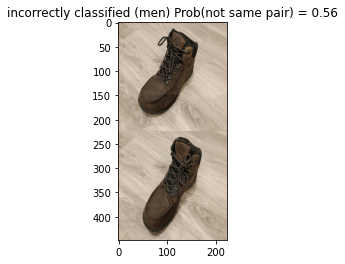

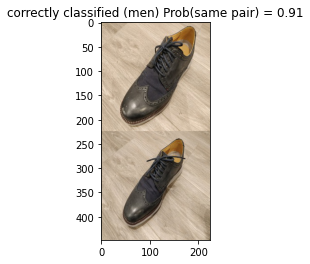

In [ ]:
model.eval()
n = test_m.shape[0]

data_pos = generate_same_pair(test_m)      # should have shape [n * 3, 448, 224, 3]

pos_correct_flag = 0
pos_incorrect_flag = 0

for i in range(0, len(data_pos)):
    xs = torch.Tensor(data_pos[i]).permute(2,0,1).unsqueeze(0)
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()

    if pred == 1 and pos_correct_flag == 0:
        pos_correct_flag=1
        plt.figure()
        plt.title('correctly classified (men) Prob(same pair) = {:.2f}'.format(F.softmax(zs, dim=1)[0,1]))
        plt.imshow(xs[0].permute(1,2,0)+0.5)
        
    
    if pred == 0 and pos_incorrect_flag == 0:
        pos_incorrect_flag=1
        plt.figure()
        plt.title('incorrectly classified (men) Prob(not same pair) = {:.2f}'.format(F.softmax(zs, dim=1)[0,0]))
        plt.imshow(xs[0].permute(1,2,0)+0.5)

    if pos_correct_flag == 1 and pos_incorrect_flag == 1:
        break
    






### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

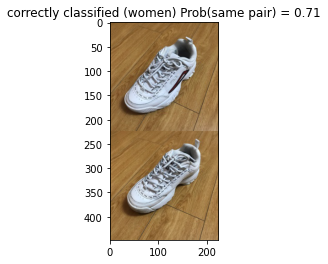

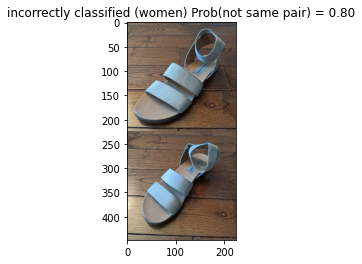

In [ ]:
model.eval()
n = test_w.shape[0]

data_pos = generate_same_pair(test_w)      # should have shape [n * 3, 448, 224, 3]

pos_correct_flag = 0
pos_incorrect_flag = 0

for i in range(0, len(data_pos)):
    xs = torch.Tensor(data_pos[i]).permute(2,0,1).unsqueeze(0)
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()

    if pred == 1 and pos_correct_flag == 0:
        pos_correct_flag=1
        plt.figure()
        plt.title('correctly classified (women) Prob(same pair) = {:.2f}'.format(F.softmax(zs, dim=1)[0,1]))
        plt.imshow(xs[0].permute(1,2,0)+0.5)
        
    
    if pred == 0 and pos_incorrect_flag == 0:
        pos_incorrect_flag=1
        plt.figure()
        plt.title('incorrectly classified (women) Prob(not same pair) = {:.2f}'.format(F.softmax(zs, dim=1)[0,0]))
        plt.imshow(xs[0].permute(1,2,0)+0.5)

    if pos_correct_flag == 1 and pos_incorrect_flag == 1:
        break
    
